In [1]:
# !git clone https://github.com/AxelThevenot/Python_Benchmark_Test_Optimization_Function_Single_Objective.git
# !mv Python_Benchmark_Test_Optimization_Function_Single_Objective/src .
# !mv Python_Benchmark_Test_Optimization_Function_Single_Objective/pybenchfunction/ .
# !ls Python_Benchmark_Test_Optimization_Function_Single_Objective/

In [50]:
import torch
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pybenchfunction as bench

import math
torch.pi = math.pi #Do I have a different version of torch?

In [51]:
# Functions with sum of terms structure

def LevyN13_i(i,x):
    w = 1+(x-1)/4
    if i==0:
        return  torch.sin(torch.pi*w[0])**2
    else:
        return  ( (w[i-1]-1)**2*(1+10*torch.sin(torch.pi*w[i-1]+1)**2)+ (w[-1]-1)**2*(1+torch.sin(2*torch.pi*w[-1])**2)         )

def PermDBeta_i(i,x):
    beta=0.5  # Added default value for beta
    v = 0
    for j in range(d):
        v+=(1+j+beta)*(x[j]**(i+1) -1. / (j+1)**(i+1))   
    return v

def Rastrigin_i(i,x):
    v = 10+x[i]**2-10*torch.cos(2*torch.pi*x[i])
    return v
    
def RosenBrock_i(i,x):
    b = 100
    a = 1
    return b * (x[i] - x[i - 1] ** 2) ** 2 + (a - x[i]) ** 2   


In [107]:

def run_SP2plus(computeValue, epochs=20, d=2, lr =1.0, x0=None):

    torch.manual_seed(0)
    if x0 is None:
        x = torch.randn(d, requires_grad=True).double()*1
    else:   
        x = torch.clone(x0)
    gdiffHvg = torch.zeros(d, requires_grad=False).double()*1
    np.random.seed(0)

    idx = list(range(d))
    x_list = []
    fval = []
    for ep in tqdm(range(epochs)):
        np.random.shuffle(idx)
        
        for i in idx:
            funci  = lambda x: computeValue(i,x)
            fi = computeValue(i,x)
            grad = torch.autograd.grad(fi,x,create_graph=True,retain_graph=True)[0]
            hessvgrad = torch.autograd.functional.hvp(funci, x, grad, create_graph=True)[1]
            # print(hessvgrad.shape)
            # hessian_grad = torch.autograd.grad(grads, self.params, grad_outputs=grads)
            with torch.no_grad():
                gradnormsqr = torch.norm(grad)**2
                if gradnormsqr > 1e-10:
                    sps_step = fi/gradnormsqr
                    x.sub_(sps_step*grad, alpha = lr)
                    # gdiffHvg = grad -hessvgrad*fi/gradnormsqr
                    gdiffHvg = torch.sub(grad, hessvgrad, alpha= sps_step)
                    # gdiffHvg = [g - fi*hg/gradnormsqr for g,hg in zip(grad, hessvgrad)]   # Maybe need this instead?
                    if torch.norm(gdiffHvg)**2 > 1e-10:
                        x.sub_(0.5*(sps_step**2)*gdiffHvg*torch.dot(grad,gdiffHvg)/ (torch.norm(gdiffHvg)**2), alpha = lr)
        fval.append(np.mean([computeValue(i,x).item() for i in range(d)]))
        x_list.append([x[0].item(),x[1].item()])
        
    return x_list, fval


In [148]:
def run_SGD(computeValue, epochs=20, d=2, lr =1.0, x0=None):

    torch.manual_seed(0)
    if x0 is None:
        x = torch.randn(d, requires_grad=True).double()*1
    else:   
        x = torch.clone(x0)

    np.random.seed(0)

    idx = list(range(d))
    x_list = []
    fval = []
    for ep in tqdm(range(epochs)):
        np.random.shuffle(idx)
        
        for i in idx:
            funci  = lambda x: computeValue(i,x)
            fi = computeValue(i,x)
            grad = torch.autograd.grad(fi,x,create_graph=True,retain_graph=True)[0]

            with torch.no_grad():
                x.sub_(grad, alpha=lr)

        fval.append(np.mean([computeValue(i,x).item() for i in range(d)]))
        x_list.append([x[0].item(),x[1].item()])
        
    return x_list, fval

def run_newton(computeValue, epochs=20, d=2, x0=None):

    torch.manual_seed(0)
    if x0 is None:
        x = torch.randn(d, requires_grad=True).double()*1
    else:   
        x = torch.clone(x0)

    np.random.seed(0)

    idx = list(range(d))
    x_list = []
    fval = []
    for ep in tqdm(range(epochs)):
        np.random.shuffle(idx)
        
        grad = torch.zeros(d)
        hess = np.zeros([d,d])
        
        for i in idx:
            funci  = lambda x: computeValue(i,x)
            fi = computeValue(i,x)
            grad_i = torch.autograd.grad(fi,x,create_graph=True,retain_graph=True)[0]
            grad.add_(grad_i)
            
            #populate the hessian for fi
            hess_i = np.zeros([d,d])
            for j in range(d):
                Hj = torch.autograd.grad(grad_i[j],x,retain_graph=True)[0]
                hess_i[:,j]=Hj
            hess_i = 0.5*(hess_i + hess_i.T) #symmetrize in case of rounding errors?
            hess = hess + hess_i

        with torch.no_grad():
            newton_step = torch.tensor(np.linalg.inv(hess) @ grad.numpy())
            x.sub_(newton_step)
        

        fval.append(np.mean([computeValue(i,x).item() for i in range(d)]))
        x_list.append([x[0].item(),x[1].item()])
        
    return x_list, fval

In [149]:
def plot_level_set_results(bench_function,x_lists, styles):
    bench.plot_2d(bench_function, n_space=100, ax=None, show=False)
    # bench.plot_3d(thevenot, n_space=100, ax=None,show=False)

    X_min, minimum = bench_function.get_global_minimum(2)
    plt.plot(X_min[0],X_min[1],'*', markersize=9, color='yellow')
    
    for x_list, sty in zip(x_lists, styles):
        for x in x_list:
            plt.plot(x[0],x[1],sty,markersize=4)
    plt.tight_layout()

    bench.plot_3d(bench_function, n_space=100, ax=None,show=False)
    plt.plot(X_min[0],X_min[1],'*', markersize=9, color='yellow')
    
    #for x_list in x_lists:
    #    for x in x_list:
    #        plt.plot(x[0],x[1],'rs',markersize=4)
    plt.tight_layout()

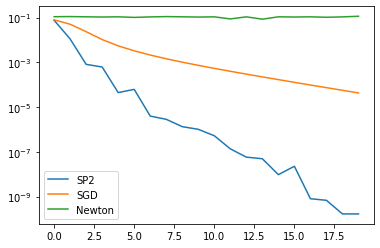

In [152]:
d=2
SP2_x_list, SP2_fval  =run_SP2plus(LevyN13_i, epochs=20, d=d)
SGD_x_list, SGD_fval  =run_SGD(LevyN13_i, epochs=20, d=d, lr=1.0)
newt_x_list, newt_fval=run_newton(LevyN13_i, epochs=20, d=d)
plt.plot(SP2_fval, label='SP2')
plt.plot(SGD_fval, label='SGD')
plt.plot(newt_fval, label='Newton')
plt.yscale('log')
plt.legend()
plt.show()

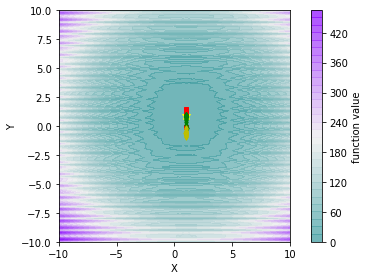

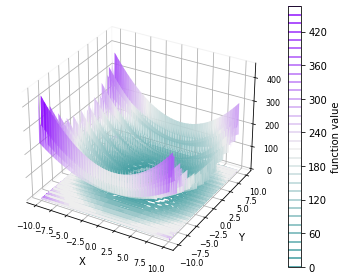

In [153]:
LevyN13 = bench.function.LevyN13(d)
plot_level_set_results(LevyN13,[SP2_x_list, SGD_x_list, newt_x_list], ['rs', 'gd','yd'])


In [116]:
#Note that there are negative values??

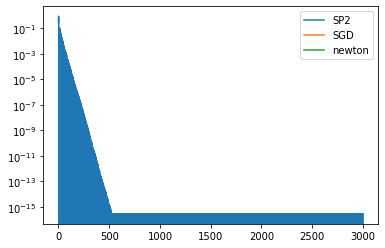

In [156]:
d=2
x0 = -torch.randn(d, requires_grad=True).double()
SP2_x_list, SP2_fval  =run_SP2plus(PermDBeta_i, epochs=3000, d=d, x0 =x0, lr = 1.0)
SGD_x_list, SGD_fval  =run_SGD(PermDBeta_i, epochs=3000, d=d, x0 =x0, lr = 0.1)
newt_x_list, newt_fval  =run_newton(PermDBeta_i, epochs=3000, d=d, x0 =x0)


plt.plot(SP2_fval, label='SP2')
plt.plot(SGD_fval, label='SGD')
plt.plot(newt_fval, label='newton')

plt.yscale('log')
plt.legend()
plt.show()

#PermDBeta = bench.function.PermDBeta(d)
#plot_level_set_results(PermDBeta,[SP2_x_list])

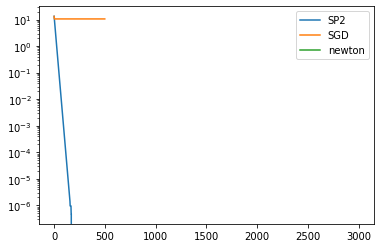

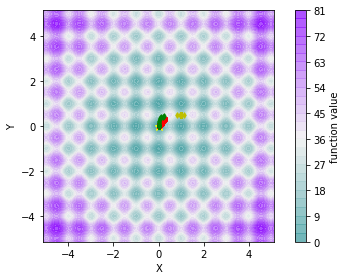

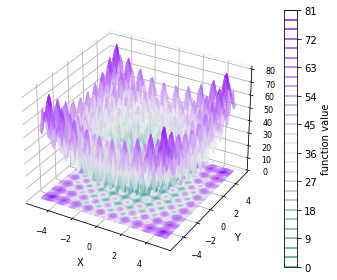

In [160]:
d=2
x0 = torch.rand(d, requires_grad=True)*0.6
SP2_x_list, SP2_fval  =run_SP2plus(Rastrigin_i, epochs=500, d=d, x0 = x0, lr = 0.1)
SGD_x_list, SGD_fval  =run_SGD(Rastrigin_i, epochs=500, d=d, x0 =x0, lr = 0.001)
newt_x_list, SGD_fval  =run_newton(Rastrigin_i, epochs=500, d=d, x0 =x0)

plt.plot(SP2_fval, label='SP2')
plt.plot(SGD_fval, label='SGD')
plt.plot(newt_fval, label='newton')

plt.yscale('log')
plt.legend()

Rastrigin = bench.function.Rastrigin(d)
plot_level_set_results(Rastrigin,[SP2_x_list, SGD_x_list, newt_x_list], ['rs','gd','yd'])

# PERM

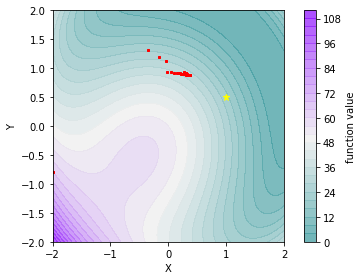

(tensor(-4.4409e-16, dtype=torch.float64, grad_fn=<AddBackward0>),
 tensor(2.2204e-16, dtype=torch.float64, grad_fn=<AddBackward0>))

In [47]:

beta = 0.5 # default value for beta
torch.manual_seed(0)
x = torch.zeros(d, requires_grad=True).double()*1

np.random.seed(0)

def computeValue(i,x):
    
    v = 0
    for j in range(d):
        v+=(1+j+beta)*(x[j]**(i+1) -1. / (j+1)**(i+1))
       
    return v 
    
computeValue(0,x),computeValue(1,x)


torch.manual_seed(1)
x = -torch.randn(d, requires_grad=True).double()*3

np.random.seed(0)
thevenot = bench.function.PermDBeta(d)
bench.plot_2d(thevenot, n_space=100, ax=None, show=False)
# bench.plot_3d(thevenot, n_space=100, ax=None,show=False)
# plt.tight_layout()

X_min, minimum = thevenot.get_global_minimum(2)


plt.plot(X_min[0],X_min[1],'*', markersize=7, color='yellow')

idx = list(range(d))
fval=[]
fval.append(np.mean([computeValue(i,x).item() for i in range(d)]))
        
plt.plot(x[0].item(),x[1].item(),'rs', markersize=2)
 
for ep in tqdm(range(1000)):
    np.random.shuffle(idx)
    
    for i in idx:
        
        v = computeValue(i,x)
        g = torch.autograd.grad(v,x,create_graph=True,retain_graph=True)[0]
        
        with torch.no_grad():
            if torch.norm(g)**2 > 1e-10:
                x.sub_(v*g/torch.norm(g)**2)
            
#         v = computeValue(i,x)
#         g = torch.autograd.grad(v,x,create_graph=True,retain_graph=True)[0]
        
#         with torch.no_grad():
#             if torch.norm(g)**2 > 1e-10:
#                 x.sub_(0.1*v*g/torch.norm(g)**2)

#             x[x>d]=d
#             x[x<-d]=-d

    fval.append(np.mean([computeValue(i,x).item() for i in range(d)]))
        
    plt.plot(x[0].item(),x[1].item(),'rs',markersize=2)
         
plt.tight_layout()

plt.show()
plt.semilogy(fval,'.')

    
 

computeValue(0,x),computeValue(1,x)

# RASTRIGIN FUNCTION

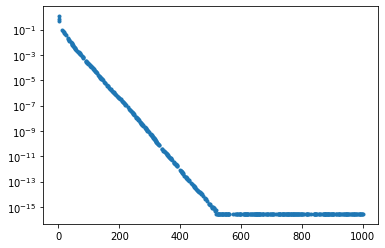

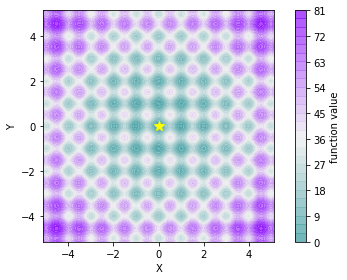

In [27]:
d=2
rastrigin = bench.function.Rastrigin(d)
bench.plot_2d(rastrigin, n_space=100, ax=None,show=False)
X_min, minimum = rastrigin.get_global_minimum(2)
plt.plot(X_min[0],X_min[1],'*', markersize=10, color='yellow')
# bench.plot_3d(rastrigin, n_space=100, ax=None,show=False)
plt.tight_layout()
# plt.savefig("./figures/sample_2D.eps")

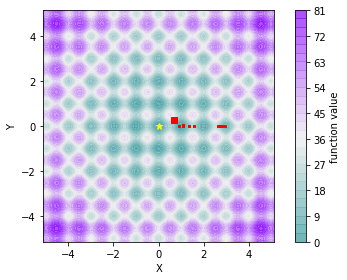

In [28]:
torch.manual_seed(0)
x = torch.zeros(d, requires_grad=True)*1

np.random.seed(0)

def computeValue(i,x):
    
    v = 10+x[i]**2-10*torch.cos(2*torch.pi*x[i])

    return v
    
computeValue(0,x),computeValue(1,x)


torch.manual_seed(1)
x = torch.randn(d, requires_grad=True)

np.random.seed(0)

bench.plot_2d(rastrigin, n_space=100, ax=None,show=False)
X_min, minimum = rastrigin.get_global_minimum(2)
plt.plot(X_min[0],X_min[1],'*', markersize=7, color='yellow')
# bench.plot_3d(rastrigin, n_space=100, ax=None,show=False)
# plt.tight_layout()
plt.tight_layout()


idx = list(range(d))
fval=[]
fval.append(np.mean([computeValue(i,x).item() for i in range(d)]))
        
plt.plot(x[0].item(),x[1].item(),'rs')
 
for ep in tqdm(range(300)):
    np.random.shuffle(idx)
    
    for i in idx:
        
        v = computeValue(i,x)
        g = torch.autograd.grad(v,x,create_graph=True,retain_graph=True)[0]
        
        with torch.no_grad():
            if torch.norm(g)**2 > 1e-10:
                x.sub_(v*g/torch.norm(g)**2)
            
        v = computeValue(i,x)
        g = torch.autograd.grad(v,x,create_graph=True,retain_graph=True)[0]
        
        with torch.no_grad():
            if torch.norm(g)**2 > 1e-10:
                x.sub_(v*g/torch.norm(g)**2)

#             x[x>d]=d
#             x[x<-d]=-d

    fval.append(np.mean([computeValue(i,x).item() for i in range(d)]))
        
    plt.plot(x[0].item(),x[1].item(),'rs',markersize=2)
         

plt.show()
plt.semilogy(fval,'.')

    


